# HW3 Benchmark Solutions Code
# Load Data

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 200
np.set_printoptions(precision=3, suppress=True)

In [44]:
train = pd.read_csv('final_data/data.csv')
holdout = pd.read_csv('final_data/holdout.csv')
hold_sol = pd.read_csv('final_data/holdout_solutions.csv')

In [45]:
holdout.columns

Index(['ID', 'age', 'job', 'marital_status', 'education', 'credit_default',
       'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration',
       'campaign', 'prev_days', 'prev_contacts', 'prev_outcomes',
       'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'nr_employed'],
      dtype='object')

In [46]:
#merge solutions in holdout:
holdout=holdout.merge(hold_sol,on='ID')

In [47]:
train.shape

(32950, 21)

## Baseline:

In [48]:
#Baseline:
train['subscribed'].value_counts()/train.shape[0]

no     0.887344
yes    0.112656
Name: subscribed, dtype: float64

In [49]:
#make outcome 0 and 1:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['subscribed'] = le.fit_transform(train['subscribed'])
#cross-check:
train['subscribed'].value_counts()/train.shape[0]

0    0.887344
1    0.112656
Name: subscribed, dtype: float64

In [50]:
holdout['subscribed'].value_counts()/holdout.shape[0]

0    0.887351
1    0.112649
Name: subscribed, dtype: float64

### Make One-Hot-Encoded variables

In [23]:
train.columns

Index(['age', 'job', 'marital_status', 'education', 'credit_default',
       'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration',
       'campaign', 'prev_days', 'prev_contacts', 'prev_outcomes',
       'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'nr_employed', 'subscribed'],
      dtype='object')

In [51]:
train.dtypes

age               float64
job                object
marital_status     object
education          object
credit_default     object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration          float64
campaign          float64
prev_days           int64
prev_contacts       int64
prev_outcomes      object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
subscribed          int64
dtype: object

In [24]:
#mark categorical and numeric variables:
categorical_vars = ['job', 'marital_status', 'education', 'credit_default',
                    'housing', 'loan',
                    'contact', 'month', 'day_of_week', 'prev_outcomes']
numeric_vars = [x for x in train.columns
                if x not in categorical_vars+['subscribed']]

In [25]:
#one-hot-encode categorical variables:
train_dummies = pd.get_dummies(train,columns=categorical_vars)
holdout_dummies = pd.get_dummies(holdout,columns=categorical_vars)
#drop because category not in test:
train_dummies.drop('credit_default_yes',axis=1,inplace=True)
train_dummies.shape, holdout_dummies.shape

((32950, 63), (8238, 64))

In [63]:
col = train.job.astype("category", ...)

category

In [57]:
train_dummies.columns

Index(['age', 'duration', 'campaign', 'prev_days', 'prev_contacts',
       'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'nr_employed', 'subscribed', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_status_divorced',
       'marital_status_married', 'marital_status_single',
       'marital_status_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'credit_default_no', 'credit_default_unknown',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun'

In [59]:
holdout_dummies.columns

Index(['ID', 'age', 'duration', 'campaign', 'prev_days', 'prev_contacts',
       'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'nr_employed', 'subscribed', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_status_divorced',
       'marital_status_married', 'marital_status_single',
       'marital_status_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'credit_default_no', 'credit_default_unknown',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'mont

In [26]:
#General model function:
from sklearn import model_selection, metrics
def modelfit(alg, dtrain, dtest, predictors, performCV=True, printFeatureImportance=False, printcoef=False, 
             export_model=False,cv_folds=5,export_name=''):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['subscribed'])
        
    #Predict train set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Predict test set:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = model_selection.cross_val_score(alg, dtrain[predictors], dtrain['subscribed'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(dtrain['subscribed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['subscribed'], dtrain_predprob))
    print("Accuracy (Test) : %.4g" % metrics.accuracy_score(dtest['subscribed'].values, dtest_predictions))
    print("AUC Score (Test) : %f" % metrics.roc_auc_score(dtest['subscribed'], dtest_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        plt.figure(figsize=(5, 10))
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values()
        feat_imp.plot(kind='barh', title='Feature Importances')
        plt.xlabel('Feature Importance Score')
        
    #export model:
    if export_model:
        dexport = dtest[['ID']].copy()
        dexport['subscribed'] = dtest_predprob
        dexport[['ID','subscribed']].to_csv('final_data/%s.csv'%export_name,index=False)

## Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [28]:
predictors = [x for x in train_dummies.columns
              if x not in ['subscribed','duration']]

In [56]:
rf=RandomForestClassifier(n_estimators=100)
params = {
    'max_leaf_nodes':list(range(10,161,10))
}
gs = GridSearchCV(rf,params,scoring='roc_auc', cv=5)
gs.fit(train_dummies[predictors],train_dummies['subscribed'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [68]:
res = pd.DataFrame(gs.cv_results_)
res = res.pivot_table(index="param_max_leaf_nodes",
                      values=["mean_test_score", "mean_train_score"])
res

,mean_test_score,mean_train_score
param_max_leaf_nodes,,
10,0.792418,0.794382
20,0.794570,0.799441
30,0.794897,0.802951
40,0.795466,0.804931
50,0.796026,0.807522
60,0.795841,0.808920
70,0.796813,0.810388
80,0.796655,0.812752
90,0.796559,0.813797


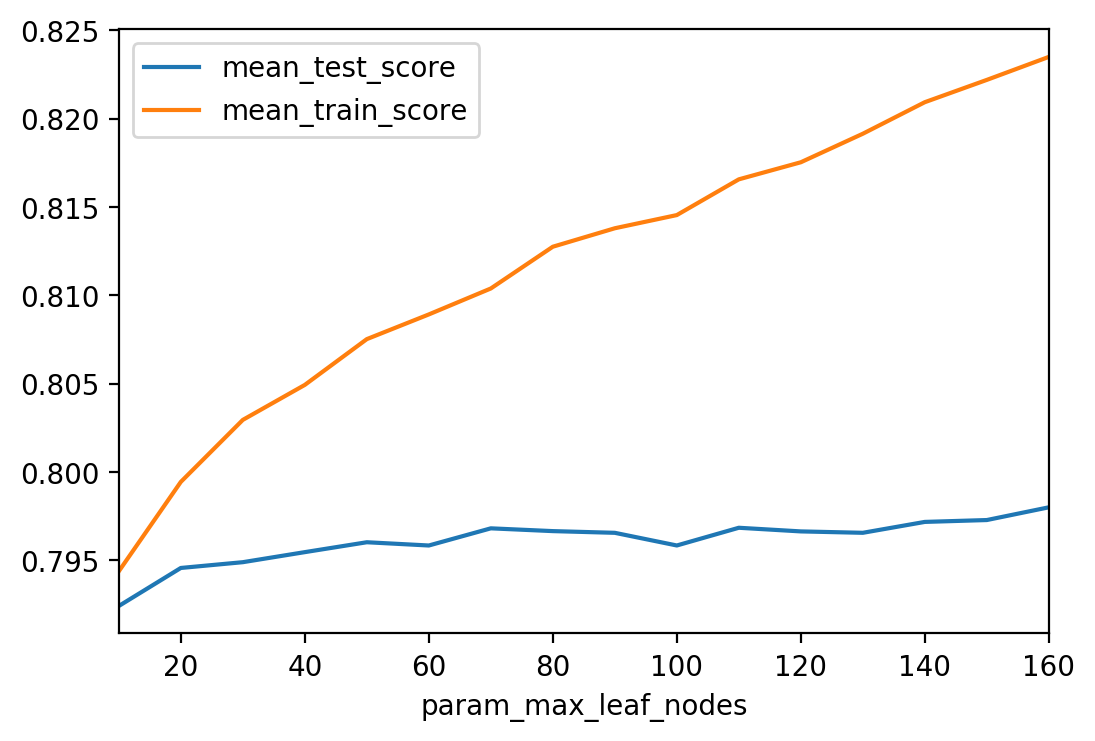

In [69]:
res.plot()

In [70]:
gs.best_params_

{'max_leaf_nodes': 160}


Model Report
Accuracy (Train) : 0.9101
AUC Score (Train): 0.818812
Accuracy (Test) : 0.9016
AUC Score (Test) : 0.784485
CV Score : Mean - 0.7979917 | Std - 0.006928329 | Min - 0.7900602 | Max - 0.8084159


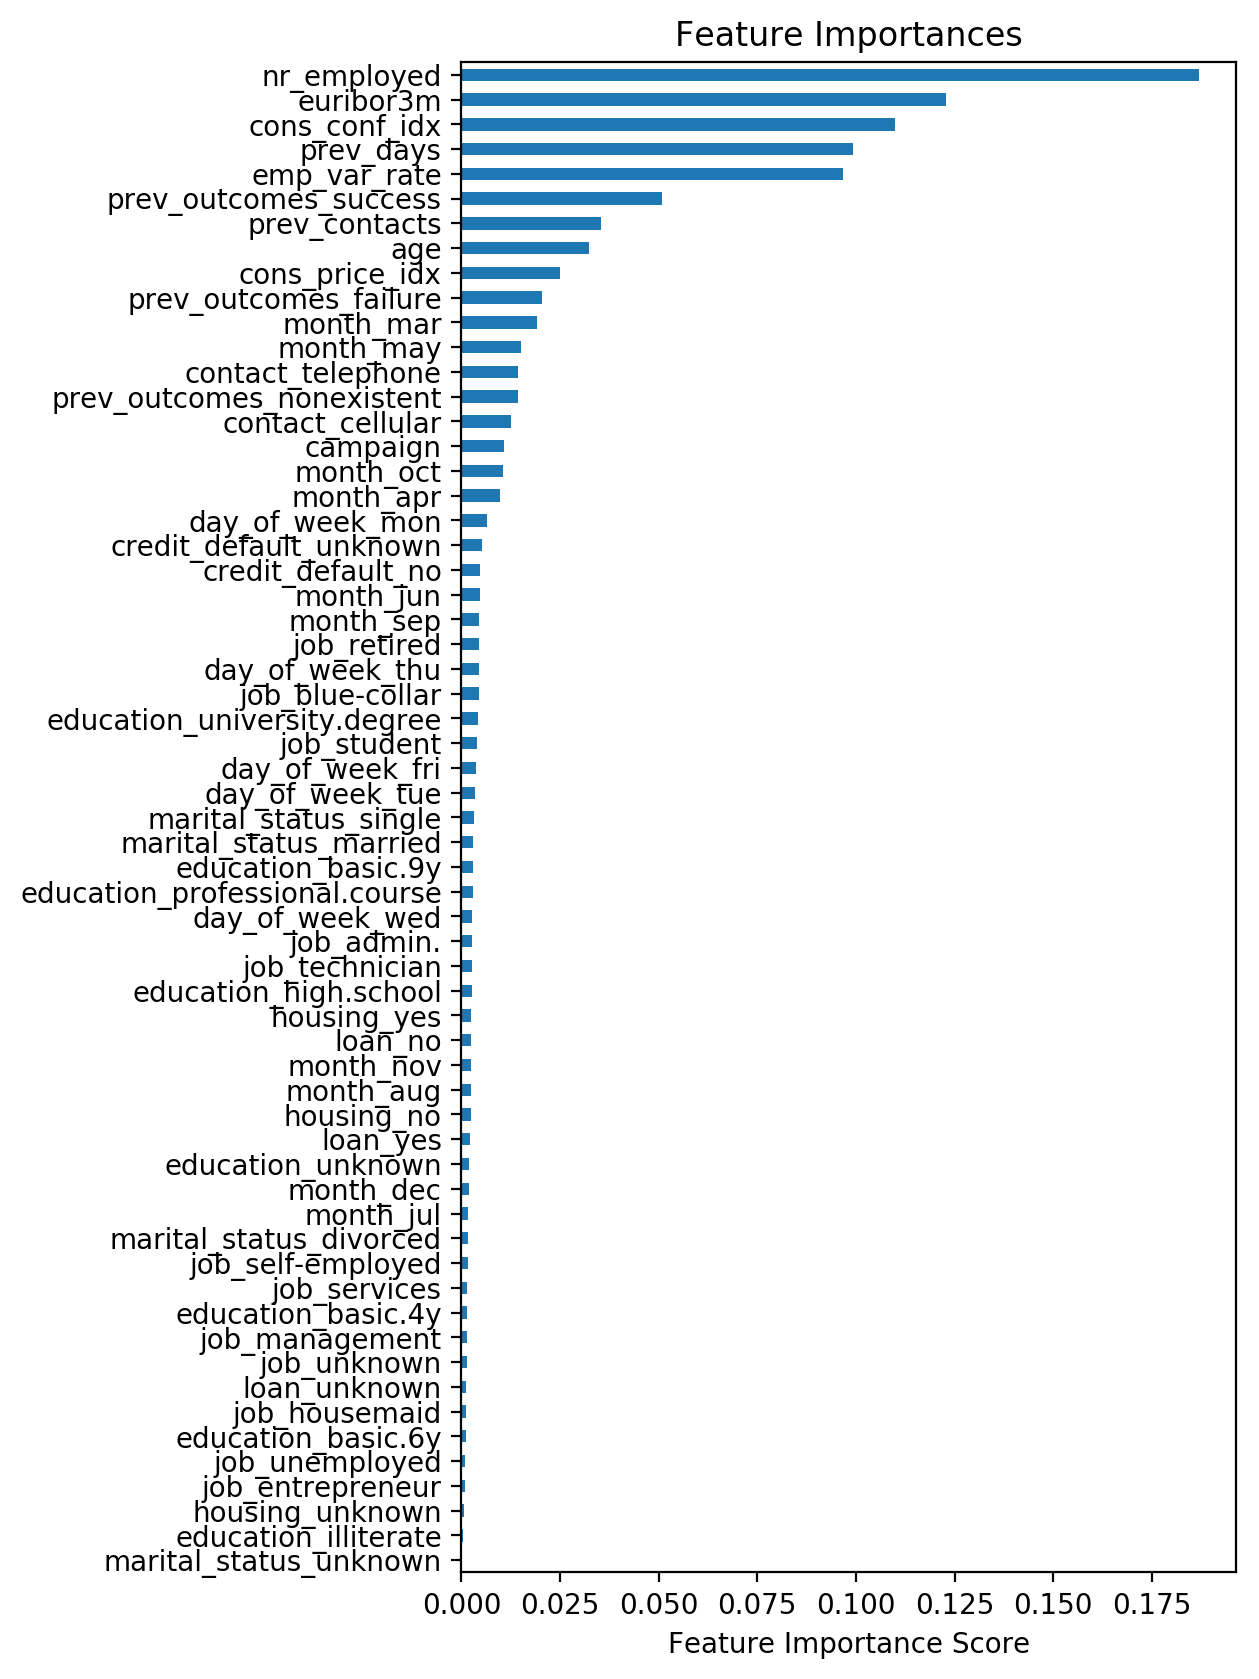

In [71]:
modelfit(gs.best_estimator_,train_dummies,holdout_dummies,predictors,performCV=True,printFeatureImportance=True)

In [33]:
modelfit(gs.best_estimator_,train_dummies,holdout_dummies,predictors,performCV=False,printFeatureImportance=False,
        export_model=True,export_name='rf_benchmark')


Model Report
Accuracy (Train) : 0.9005
AUC Score (Train): 0.857561
Accuracy (Test) : 0.8992
AUC Score (Test) : 0.784967


## Dummy Classifier:

In [34]:
from sklearn.dummy import DummyClassifier

In [35]:
dc = DummyClassifier(strategy='prior')
modelfit(dc,train_dummies,holdout_dummies,predictors,performCV=False,printFeatureImportance=False,export_model=True,
        export_name='dummy_benchmark')


Model Report
Accuracy (Train) : 0.8873
AUC Score (Train): 0.500000
Accuracy (Test) : 0.8874
AUC Score (Test) : 0.500000


## Logistic Regression

In [36]:
#normalize the numeric columns:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_dummies[numeric_vars] = scaler.fit_transform(train_dummies[numeric_vars])
holdout_dummies[numeric_vars] = scaler.transform(holdout_dummies[numeric_vars])

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
logreg = LogisticRegression()
modelfit(logreg,train_dummies,holdout_dummies,predictors,performCV=True,printFeatureImportance=False,printcoef=True,export_model=True,
        export_name='logistic_benchmark')


Model Report
Accuracy (Train) : 0.9001
AUC Score (Train): 0.795072
Accuracy (Test) : 0.8994
AUC Score (Test) : 0.783141
CV Score : Mean - 0.7912937 | Std - 0.005807576 | Min - 0.7840831 | Max - 0.7989825


In [72]:
logreg = LogisticRegression(class_weight="balanced")
modelfit(logreg,train_dummies,holdout_dummies,predictors,performCV=True,printFeatureImportance=False,printcoef=True,export_model=True,
        export_name='logistic_benchmark')


Model Report
Accuracy (Train) : 0.821
AUC Score (Train): 0.797576
Accuracy (Test) : 0.8225
AUC Score (Test) : 0.784263
CV Score : Mean - 0.7929947 | Std - 0.006020472 | Min - 0.784716 | Max - 0.8013474
